# Import Packages

In [252]:
import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from skBernoulliNBn.pipeline import Pipeline
from string import punctuation
import nltk
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
from sklearn.metrics import roc_curve, roc_auc_score



# Data Wrangling/Gathering/Acquisition

In [253]:
url = "https://api.pushshift.io/reddit/search/submission" 

In [254]:
# Automating the web scraping
def scrap_num(url, sub = None, size = 500, before = None):
    params = {
        "subreddit": sub,
        "size": size,
        "before": before
    }
    lst = []
    for i in range(15):
        res = requests.get(url, params)
        lst.extend(res.json()["data"])
        params["before"] = res.json()["data"][-1]["created_utc"]
        time.sleep(2)
    return lst

In [255]:
# scrape for boardgame
board_posts = scrap_num(url, sub = "boardgames", size = 500, before = 1632957304)


In [256]:
# scrape for the videogame
video_posts = scrap_num(url, sub = "videogames", size = 200, before = 1480143096)

In [258]:
# video_posts[:2]

In [259]:
# len(video_posts)

In [260]:
# conver the json to data frame
board_df = pd.DataFrame(board_posts)
board_df.head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,...,media,media_embed,removed_by_category,secure_media,secure_media_embed,suggested_sort,crosspost_parent,crosspost_parent_list,edited,author_cakeday
0,[],False,GuysoftheBeholder,None,[],None,text,t2_egig5h3d,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,seekerof_,None,[],None,text,t2_eu9sx0ez,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,IdeaShark516,None,[],None,text,t2_ap7vpzb0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,DistinctFudge8740,None,[],None,text,t2_ellkb6gs,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,Juranur,hive,"[{'e': 'text', 't': 'Hive'}]",Hive,richtext,t2_2fftpfe3,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [261]:
# select some features for the board game
board_df = board_df[["subreddit", "selftext", "title"]]

In [262]:
# convert the video game json to data frame
video_df = pd.DataFrame(video_posts)
# select teh three columns
video_df = video_df[["subreddit", "selftext", "title"]]

In [263]:
board_df['title']

0       If you were to open your dream LGS, what would...
1       How did you decide on what games to add to you...
2       Recommendations for getting a 6 year old hooke...
3       Why does the board game community dislike King...
4       We played the largest game of Carcassonne we c...
                              ...                        
1495                    Catan 3D Production Inconsistency
1496                     Catan 3D Production Inconsitency
1497    I bought all of these games for $47 at my loca...
1498    What are some dice games that don't feel luck ...
1499            A beginners guide to fantasy board gaming
Name: title, Length: 1500, dtype: object

In [264]:
# generate the string length for the particular reviews
board_df['text'] = board_df[["selftext", "title"]].agg('-'.join, axis=1)
board_df["count"] = board_df['text'].apply(lambda x : len(str(x)))

In [265]:
board_df.head()

,subreddit,selftext,title,text,count
0,boardgames,"If resources, time, and space were not a prob...","If you were to open your dream LGS, what would...","If resources, time, and space were not a prob...",716
1,boardgames,I'm very particular now on the things I buy or...,How did you decide on what games to add to you...,I'm very particular now on the things I buy or...,1153
2,boardgames,I've been in the process of getting my daughte...,Recommendations for getting a 6 year old hooke...,I've been in the process of getting my daughte...,356
3,boardgames,I mean he doesn't get paid to say he likes gam...,Why does the board game community dislike King...,I mean he doesn't get paid to say he likes gam...,172
4,boardgames,"So, me and a couple friends really enjoy Carca...",We played the largest game of Carcassonne we c...,"So, me and a couple friends really enjoy Carca...",2231


In [266]:
# merge the two columns of video df
video_df['text'] = video_df[["selftext",  "title"]].agg('-'.join, axis=1)

In [267]:
# generate the length of the review for the video game
video_df["count"] = video_df['text'].apply(lambda x : len(str(x)))

In [268]:
video_df.head()

,subreddit,selftext,title,text,count
0,videogames,,Top 15 Anticipated Horror Games 2016 Part 2,-Top 15 Anticipated Horror Games 2016 Part 2,44
1,videogames,Thoughts on the last of us 2 going to be annou...,The Last of Us 2,Thoughts on the last of us 2 going to be annou...,89
2,videogames,,Zenith: Funny Garbage,-Zenith: Funny Garbage,22
3,videogames,,Father &amp; Son bonding in GTA 5,-Father &amp; Son bonding in GTA 5,34
4,videogames,,Anniversary Present,-Anniversary Present,20


In [269]:
# concat teh vidoe and boardgame to make a bigger data
frames = [board_df, video_df]
big_df = pd.concat(frames) #board_df.append(video_df, ignore_index=True)

In [270]:
# labell the catgorical column with 1 and 0
big_df["subreddit"] = big_df["subreddit"].map({"videogames": 1, "boardgames":0})

# Exploratory Data Analysis

In [271]:
# update the count column of the big data
big_df["count"] = video_df["count"]+ board_df["count"]

In [272]:
big_df.head()

,subreddit,selftext,title,text,count
0,0,"If resources, time, and space were not a prob...","If you were to open your dream LGS, what would...","If resources, time, and space were not a prob...",760
1,0,I'm very particular now on the things I buy or...,How did you decide on what games to add to you...,I'm very particular now on the things I buy or...,1242
2,0,I've been in the process of getting my daughte...,Recommendations for getting a 6 year old hooke...,I've been in the process of getting my daughte...,378
3,0,I mean he doesn't get paid to say he likes gam...,Why does the board game community dislike King...,I mean he doesn't get paid to say he likes gam...,206
4,0,"So, me and a couple friends really enjoy Carca...",We played the largest game of Carcassonne we c...,"So, me and a couple friends really enjoy Carca...",2251


In [273]:
# check the null value for the big data
big_df.isna().sum()

subreddit    0
selftext     0
title        0
text         0
count        0
dtype: int64

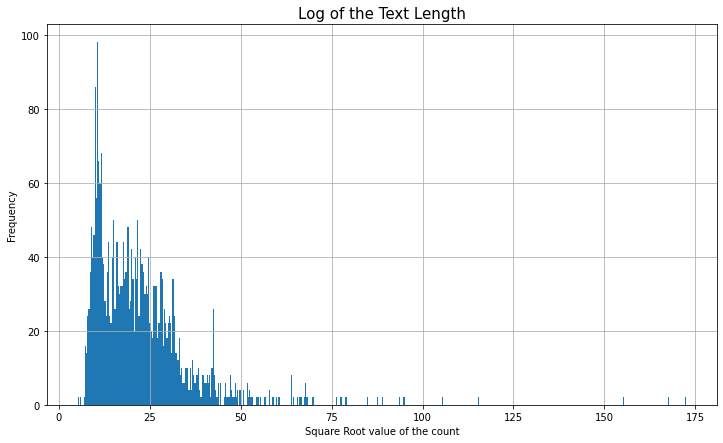

In [274]:
# histogram visualization of the square root of count column
plt.figure(figsize = (12, 7));
np.sqrt(big_df["count"]).hist(bins = 500);
plt.ylabel("Frequency");
plt.xlabel("Square Root value of the count");
plt.title("Log of the Text Length", fontsize = 15);

## Summary Statistics

In [275]:
big_df["count"].describe()

count     3000.000000
mean       696.448000
std       1532.773453
min         26.000000
25%        150.750000
50%        388.000000
75%        770.250000
max      29772.000000
Name: count, dtype: float64

# Natural Language Processing

In [277]:
# generate the stopword for english
stop = stopwords.words('english')
# stop = stop.extend(["com", "etc", "ela", "la"])

In [331]:
# func to remove punctuations
def remove_punctuation(sentence): 
    return sentence.translate(str.maketrans('', '', string.punctuation))

# func remove stop words
def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

# achange the string to lowercase
def to_lower(x):
    return x.lower()
# remove the numerical data values
def remove_nonenglish_words(x):
    words = set(nltk.corpus.words.words())
    filtered = " ".join(w for w in nltk.wordpunct_tokenize(x) \
                                if w.lower() in words or not w.isalpha())
    return filtered
# function to remove the url linka from the review
def remove_url(text):
  
  return re.sub(r"http\S+", "", text)


In [332]:
# Apply the the functions on the datasets
porter = PorterStemmer()
big_df['text'] = big_df['text'].apply(porter.stem)
big_df['text'] = big_df['text'].apply(remove_punctuation)
big_df['text'] = big_df['text'].apply(remove_stop_words)
big_df['text'] = big_df['text'].apply(to_lower)
big_df['text'] = big_df['text'].apply(remove_url)

In [281]:
big_df['text'] = big_df['text'].apply(remove_nonenglish_words)
board_df['text'] = board_df['text'].apply(remove_nonenglish_words)
video_df['text'] = video_df['text'].apply(remove_nonenglish_words)

In [333]:
# function to remove the numeric values from the str
def remove_numeric(text):
    result = ''.join([i for i in text if not i.isdigit()])
    return result

In [334]:
# apply the remove_numeric funct on the datasets
big_df['text'] = big_df['text'].apply(remove_numeric)

In [335]:
big_df["count_update"] = big_df['text'].apply(lambda x : len(str(x)))

### Visualized the processed review length

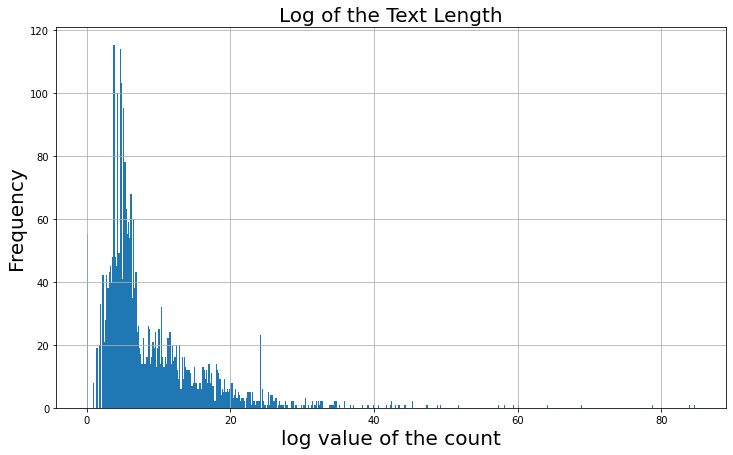

In [336]:
# hist plot for squre root of the updated count
plt.figure(figsize = (12, 7));
np.sqrt(big_df["count_update"]).hist(bins = 500);
plt.ylabel("Frequency", fontsize=20);
plt.xlabel("log value of the count", fontsize=20);
plt.title("Log of the Text Length", fontsize = 20);

### Transfrom with CountVectorizer 

In [337]:
# Transfrom with CountVectorizer 
cvec = vec = CountVectorizer(ngram_range=(3, 3), stop_words='english')

# Fit and transform the vectorizer on our corpus.
cvec.fit_transform(board_df["text"])

board_tf_df = pd.DataFrame(board_tf.todense(), 
                          columns=cvec.get_feature_names())

## Plot top occuring words

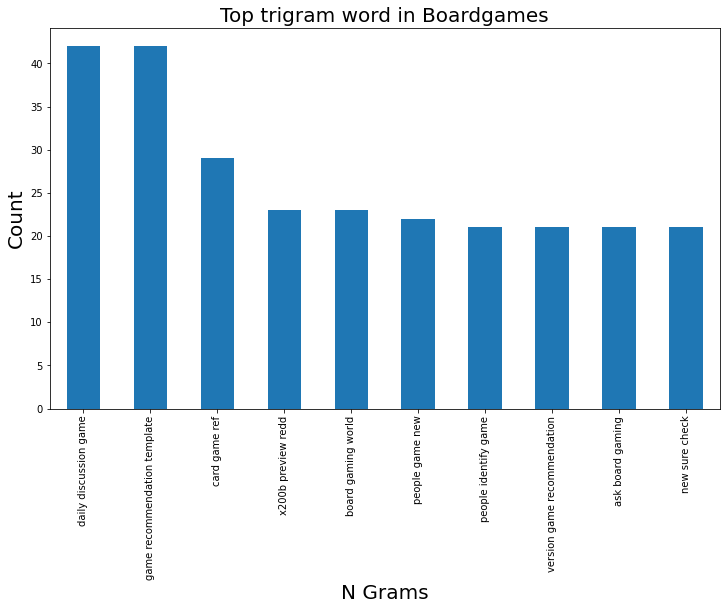

In [338]:
# Bar plot for the top trigram words
plt.figure(figsize = (12, 7));
board_tf_df.sum().sort_values(ascending = False).head(10).plot(kind = "bar");
plt.ylabel("Count", fontsize = 20);
plt.xlabel("N Grams", fontsize = 20);
plt.title("Top trigram word in Boardgames", fontsize = 20);

In [339]:
# Transform with CountVectorizer 
vec = CountVectorizer(ngram_range=(3, 3), stop_words= "english")

# Fit the vectorizer on our corpus.
vec.fit_transform(video_df["text"])

video_tf_df = pd.DataFrame(video_tf.todense(), 
                          columns=vec.get_feature_names())

In [340]:
video_tf_df.head()

,000 gaming experience,000 han la,10 14 el,10 acceder la,10 best latest,10 best video,10 card game,10 card got,10 edition es,10 edition pocket,...,youd probably high,young team south,zenith funny garbage,zero escape nonary,zero gravity popular,zero hour game,zero stole concept,zombie apocalypse zombie,zombie night terror,zombie survival ps3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


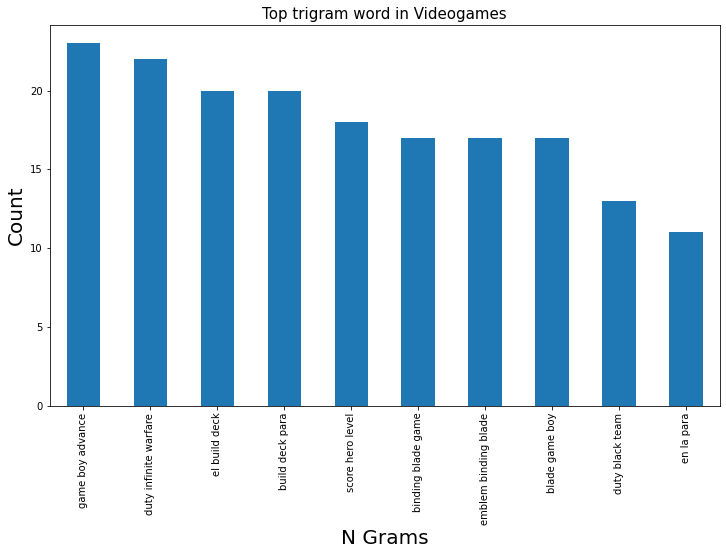

In [341]:
plt.figure(figsize = (12, 7));
video_tf_df.sum().sort_values(ascending = False).head(10).plot(kind = "bar");
plt.ylabel("Count", fontsize= 20);
plt.xlabel("N Grams", fontsize= 20);
plt.title("Top trigram word in Videogames", fontsize = 15);

# Classification Modeling

In [342]:
# X and Y datasest Extracting 
X = big_df["text"]
y = big_df["subreddit"]

In [343]:
# Traing and test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)

## Apply the TF-iDF Transformers

In [344]:
# use the TDIDF 
tv = TfidfVectorizer(max_features=35000, ngram_range=(1, 2), stop_words='english')
X_train_tf = tv.fit_transform(X_train)

In [345]:
# genrate teh dataframe of tranformed X_train
X_train_df = pd.DataFrame(X_train_tf.todense(), columns = tv.get_feature_names())
X_train_df.head()

,abductor,abductor demand,ability,ability alter,ability determine,ability half,ability learn,ability let,ability magic,ability missile,...,zombie similar,zombie solo,zombie survival,zone,zone tag,zoo,zoo la,zoo probably,zoom,zoom discord
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [346]:
#lecture 5.04 with Noah
# create a dictionary mapping the tokens to their tfidf values
X_tf_tf = dict(zip(tv.get_feature_names(), tv.idf_))
X_tf_df = pd.DataFrame(columns=['tfidf_vallues']).from_dict(
                    dict(X_tf_tf), orient='index')
X_tf_df.columns = ['tfidf_values']

# Hihest TFIDF Scores
X_tf_df.sort_values(by=['tfidf_values'], ascending=False).head(10)

,tfidf_values
abductor,7.957022
perspective share,7.957022
perspective love,7.957022
personally want,7.957022
personally turned,7.957022
personally really,7.957022
personally mind,7.957022
personally love,7.957022
personally looking,7.957022
personally interested,7.957022


In [347]:
X_tf_df

,tfidf_values
abductor,7.957022
abductor demand,7.957022
ability,6.011111
ability alter,7.957022
ability determine,7.957022
...,...
zoo,7.551556
zoo la,7.957022
zoo probably,7.957022
zoom,7.957022


In [348]:
# Transfrom the X_test
# from lecture 5.04 with Noah
X_test_tf = tv.transform(X_test)

X_test_df = pd.DataFrame(X_test_tf.todense(), columns = tv.get_feature_names())
X_test_df.head()

,abductor,abductor demand,ability,ability alter,ability determine,ability half,ability learn,ability let,ability magic,ability missile,...,zombie similar,zombie solo,zombie survival,zone,zone tag,zoo,zoo la,zoo probably,zoom,zoom discord
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [349]:
print(X_train_df.shape)
print(X_test_df.shape)
print(y_train.shape)
print(y_test.shape)

(2100, 32267)
(900, 32267)
(2100,)
(900,)


### Baseline model

In [350]:
# baseline model
y.value_counts(normalize = True)

0    0.5
1    0.5
Name: subreddit, dtype: float64

# Initiate and Fit Classification model and Evaluations

In [351]:
# initiate the logistic Regression 
lr =LogisticRegression()

In [352]:
# fit the model
lr.fit(X_train_df, y_train)

LogisticRegression()

In [353]:
# calculate the accuracy of training data 
lr.score(X_train_df, y_train)

0.969047619047619

In [354]:
# calculate the accuracy of the testing data
lr.score(X_test_df, y_test)

0.8766666666666667

In [355]:
## Define a function generate the confusion matrix
def plot_confusion_matrix(dt):
    sns.heatmap(dt, annot=True, xticklabels=['Pred Neg', 'Pred Pos'],
              yticklabels = ['Actual Neg', 'Actual Pos'])

## Develope a Pipline and Cofusion matrix

NB Training Accuray: 0.7795238095238095
NB Testing Accuracy:  0.7911111111111111


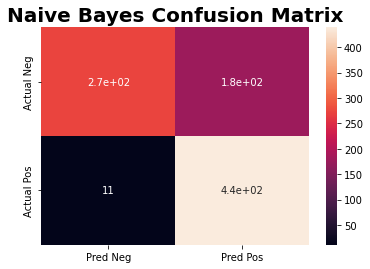

In [377]:
# naive Bayes pipline with the TF-iDF
model_dict = {}
lr = Pipeline([
                ('tfidf', TfidfVectorizer()),
               ('clf', BernoulliNB())])
    
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_pred = lr.predict(X_test)

print(f"NB Training Accuray: {accuracy_score(y_train, y_train_pred)}")
print(f"NB Testing Accuracy:  { accuracy_score(y_test, y_pred)}")
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
plt.title("Naive Bayes Confusion Matrix", fontweight = "bold", fontsize = 20)
model_dict["NB_tfidf_train"] = accuracy_score(y_train, y_train_pred)
model_dict["NB_tfidf_test"] = accuracy_score(y_test, y_pred)

Training Accuray: 0.9466666666666667
Testing Accuracy:  0.8755555555555555


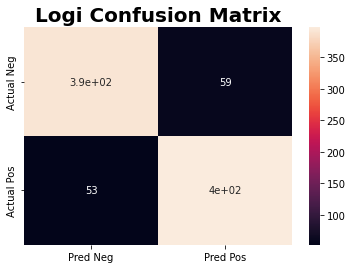

In [378]:
# Logistic regression pipline with the TF-iDF

lr = Pipeline([
                ('tfidf', TfidfVectorizer()),
               ('clf', LogisticRegression())])
    
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_pred = lr.predict(X_test)

print(f"Training Accuray: {accuracy_score(y_train, y_train_pred)}")
print(f"Testing Accuracy:  { accuracy_score(y_test, y_pred)}")
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
plt.title("Logi Confusion Matrix", fontweight = "bold", fontsize = 20)
model_dict["Log_tfidf_train"] = accuracy_score(y_train, y_train_pred)
model_dict["Log_tfidf_test"] = accuracy_score(y_test, y_pred)

Training Accuray: 0.9904761904761905
Testing Accuracy:  0.87


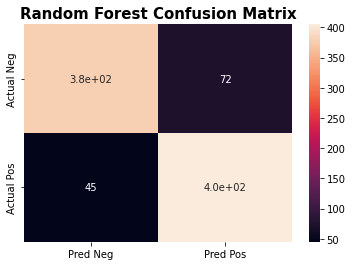

In [379]:
# pip line for random forest with TF-iDF
pip = Pipeline([
                ('tfidf', TfidfVectorizer()),
               ('clf', RandomForestClassifier())])
    
pip.fit(X_train, y_train)
y_train_pred = pip.predict(X_train)
y_pred = pip.predict(X_test)

print(f"Training Accuray: {accuracy_score(y_train, y_train_pred)}")
print(f"Testing Accuracy:  { accuracy_score(y_test, y_pred)}")
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
plt.title("Random Forest Confusion Matrix", fontsize = 15, fontweight = "bold")
model_dict["Rnd_tfidf_train"] = accuracy_score(y_train, y_train_pred)
model_dict["Rnd_tfidf_test"] = accuracy_score(y_test, y_pred)

Training Accuray: 0.9623809523809523
Testing Accuracy:  0.8733333333333333


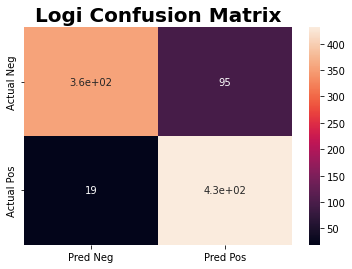

In [380]:
# pip line for logistic regression with ConutVectorizer
pip = Pipeline([
                    ('tfidf',CountVectorizer()),
               ('clf', LogisticRegression())])
    
pip.fit(X_train, y_train)
y_train_pred = pip.predict(X_train)
y_pred = pip.predict(X_test)

print(f"Training Accuray: {accuracy_score(y_train, y_train_pred)}")
print(f"Testing Accuracy:  { accuracy_score(y_test, y_pred)}")

plot_confusion_matrix(confusion_matrix(y_test, y_pred))
plt.title("Logi Confusion Matrix", fontweight = "bold", fontsize = 20)
model_dict["Log_vc_train"] = accuracy_score(y_train, y_train_pred)
model_dict["Log_vc_test"] = accuracy_score(y_test, y_pred)

Training Accuray: 0.9904761904761905
Testing Accuracy:  0.8833333333333333


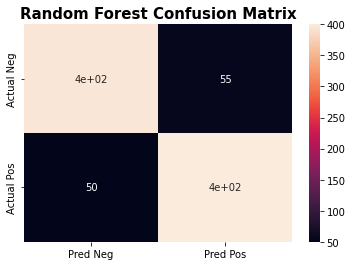

In [381]:
# pip line for random forest with ConutVectorizer
pip = Pipeline([
                    ('tfidf',CountVectorizer()),
               ('clf', RandomForestClassifier())])
    
pip.fit(X_train, y_train)
y_train_pred = pip.predict(X_train)
y_pred = pip.predict(X_test)

print(f"Training Accuray: {accuracy_score(y_train, y_train_pred)}")
print(f"Testing Accuracy:  { accuracy_score(y_test, y_pred)}")
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
plt.title("Random Forest Confusion Matrix", fontsize = 15, fontweight = "bold")
model_dict["Rnd_vc_train"] = accuracy_score(y_train, y_train_pred)
model_dict["Rnd_vc_test"] = accuracy_score(y_test, y_pred)

In [382]:
model_df = pd.DataFrame(model_dict.items(), columns = ["Model", "Accuracy"])
model_df

,Model,Accuracy
0,NB_tfidf_train,0.779524
1,NB_tfidf_test,0.791111
2,Log_tfidf_train,0.946667
3,Log_tfidf_test,0.875556
4,Rnd_tfidf_train,0.990476
5,Rnd_tfidf_test,0.870000
6,Log_vc_train,0.962381
7,Log_vc_test,0.873333
8,Rnd_vc_train,0.990476
9,Rnd_vc_test,0.883333


## Automating the modeling process for different classification models

In [375]:
# List of Models I want to try on 
models = [LogisticRegression(), 
               DecisionTreeClassifier(random_state=1234), 
               RandomForestClassifier(random_state=1234), 
         BernoulliNB() ]



#Code from https://www.imranabdullah.com/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot
# initial a empty dataframe
metrics_table = pd.DataFrame(columns=['model', 'fpr','tpr','auc'])
# Train the models and record the results
for pip in models:
    pip.fit(X_train_df, y_train)
    y_train_pred = pip.predict_proba(X_train_df)[:,1]
    y_pred = pip.predict_proba(X_test_df)[:,1]
#     print(y)
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    metrics_table = metrics_table.append({'model':pip.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the models as index labels
metrics_table.set_index('model', inplace=True)

In [363]:
metrics_table

,fpr,tpr,auc
model,,,
LogisticRegression,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0022222222222222222, 0.046666666666666...",0.944274
DecisionTreeClassifier,"[0.0, 0.13555555555555557, 0.24, 0.24, 1.0]","[0.0, 0.6577777777777778, 0.8533333333333334, ...",0.831985
RandomForestClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.11777777777777777, 0.12222222222222222...",0.950970
BernoulliNB,"[0.0, 0.14444444444444443, 0.1622222222222222,...","[0.0, 0.9155555555555556, 0.9222222222222223, ...",0.909279


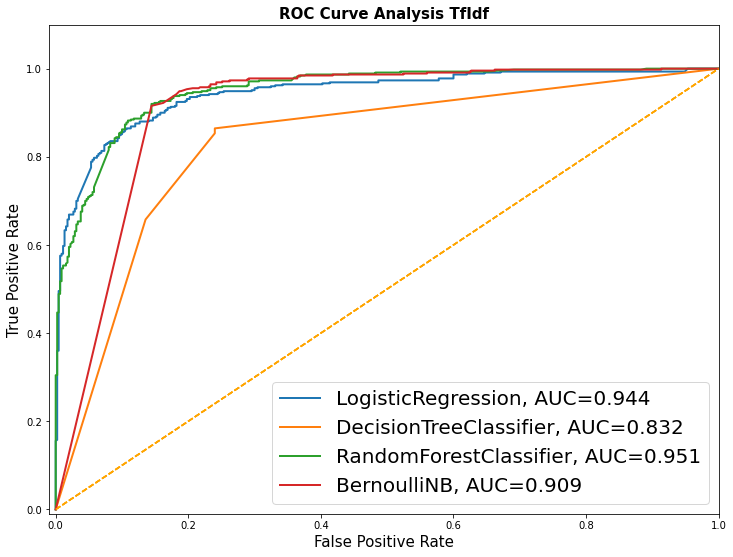

In [364]:
# https://www.imranabdullah.com/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot
plt.figure(figsize = (12, 9))
for i in metrics_table.index:
    plt.plot(metrics_table.loc[i]['fpr'], 
             metrics_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, metrics_table.loc[i]['auc']), linewidth= 2 )
    
    plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xlabel("False Positive Rate", fontsize=15)
plt.xlim(-0.01,1.0)
plt.ylim(-0.01,1.1)

plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis TfIdf', fontweight='bold', fontsize=15)
plt.legend(prop={'size':20}, loc='lower right')

plt.show()

## Interpretation:
- the baseline model has a .5 accuracy which bad compare to the classification models
- Want to reduce the false false positive and false negatives.
- Random forest has better traing accuracy, but there is large gap with testing accuarcy.
- Logistic Reg. is better because less overfit, so I choose it my main classification model
ven the ROC curve of random forest is above the logistic 
-  ”Probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative instance for AUC values mean”

source: https://www.displayr.com/what-is-a-roc-curve-how-to-interpret-it/


# Conclusion and Recomendations

- All the Data Science steps executed we have discovered pattern from the messy data.
- We have developed an  logarithms that able classify the reviews or tweets in 0.94 on training and .88 on testing accuracy.

**Future Work:**
- Tune some the hyperparameter and more train the model
- Deploy this model to the production



